# Galician POSTagger

To train a Galician POS tagger, we will use the [Galician UD treebank](https://github.com/UniversalDependencies/UD_Galician-CTG) dataset. This dataset is a part of the Universal Dependencies project and contains 3,993 sentences and 138,837 words. The Galician UD treebank is based on the automatic parsing of the [Galician Technical Corpus](http://sli.uvigo.gal/CTG) created at the University of Vigo by the the TALG NLP research group.

There are two additional datasets available for Galician POS tagging. These other datasets offer higher quality, as they include verb forms and other morphological details. However, for this assignment, we will focus on building a simple POS tagger without these extra features. As the Galician UD Treebank is the largest dataset available, we will prioritize its use. A comparison of the datasets can be found [here](https://universaldependencies.org/treebanks/gl-comparison.html).


In [38]:
from tagger import MyTagger
from utils import *

## Preprocessing

Similarily to as we did with English, we are going to preprocess the Galician UD treebank dataset. We are interested in the lenght of the sentences and in the number of distinct words in the dataset. With this information, we can adjust the padding added to all sentences and the size of the vocabulary.


In [39]:
gal_tagger = MyTagger(
    train_filename="data/galician/CTG/gl_ctg-ud-train.conllu",
    val_filename="data/galician/CTG/gl_ctg-ud-dev.conllu",
    test_filename="data/galician/CTG/gl_ctg-ud-test.conllu",
)

In [40]:
train_sentences, train_words, val_sentences, val_words, test_sentences, test_words = calculate_statistics_tagger_data(
    gal_tagger
)

print(f"Training dataset - sentences: {train_sentences}, words: {train_words}")
print(f"Validation dataset - sentences: {val_sentences}, words: {val_words}")
print(f"Test dataset - sentences: {test_sentences}, words: {test_words}")

Training dataset - sentences: 2272, words: 79327
Validation dataset - sentences: 860, words: 29772
Test dataset - sentences: 861, words: 29738


Similarly to our approach with English, we will limit the maximum sequence length. Initially, we'll set this maximum to 100 and examine how many sentences exceed this limit, as well as identify the longest sentence in the dataset.

We found that the longest sentence in the dataset has 88 tokens, so we will set the maximum sequence length to 88, to not lose any information and to avoid unnecessary padding.


In [41]:
max_sentence_num_words = 100
mean_len, std_len, max_len, sentences_over_max_length = calculate_statistics_dataset(
    gal_tagger.X_train, max_sentence_num_words=max_sentence_num_words
)

print(f"Mean sentence length: {round(mean_len, 2)}")
print(f"Standard deviation of sentence length: {round(std_len, 2)}")
print(f"Max sentence length: {round(max_len, 2)}")

print(f"Number of sentences over {max_sentence_num_words} words: {len(sentences_over_max_length)}")
print(
    f"Percentage of sentences over {max_sentence_num_words} words: {len(sentences_over_max_length) / len(gal_tagger.X_train) * 100:.2f}%\n"
)
for i, sentence in enumerate(sentences_over_max_length):
    print(
        f'Sentence {i} has more than {max_sentence_num_words} words ({len(sentence.split())}). Sentence: "{sentence}"'
    )

Mean sentence length: 34.92
Standard deviation of sentence length: 8.48
Max sentence length: 88
Number of sentences over 100 words: 0
Percentage of sentences over 100 words: 0.00%



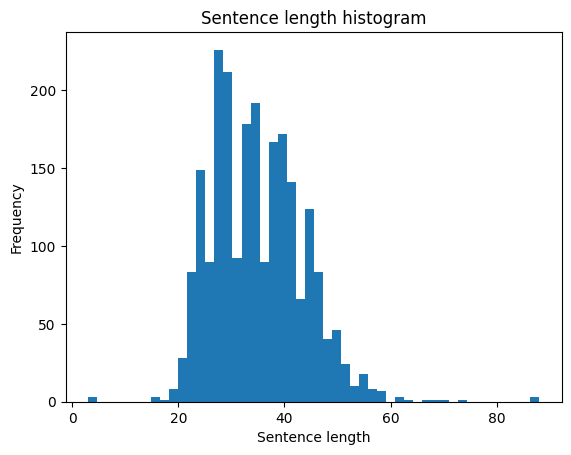

In [42]:
plot_sentence_length_histogram(gal_tagger.X_train)

In [43]:
# max_sentence_num_words = 88
gal_tagger.preprocess_data(max_sentence_num_words=88, with_punctuation=True)
print(f"Sentence 1: {gal_tagger.X_train[0]}")
print(f"Label 1: {gal_tagger.y_train[0]}")

Sentence 1: De novo , aprecia se unha significativa dependencia entre o nivel de acceso a a Internet e determinadas características socioeconómicas de os territorios , o que aporta o xa citado factor de matiz importante sobre a avaliación de os datos anteriores .
Label 1: [ 2  1 13 16 11  6  1  8  2  6  8  2  8  2  6 12  5 16  8  1  2  6  8 13
  6 11 16  6  3 16  8  2  8  1  2  6  8  2  6  8  1 13  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


We are going to use a vocabulary size of 10,000 words, as the vocabulary size of the Galician UD treebank is 12,406 words.


In [44]:
X_plain_train = {token for sentence in gal_tagger.X_train for token in sentence.split()}
print(f"Number of unique tokens: {len(X_plain_train)}")

X_plain_test = {token for sentence in gal_tagger.X_test for token in sentence.split()}
print(f"Number of unique tokens: {len(X_plain_test)}")

Number of unique tokens: 12406
Number of unique tokens: 6767


## Model training

First, we are going to train a model with the following hyperparameter configuration:

- LSTM units: 64
- Embedding size: 50
- Batch size: 64
- Bidirectional LSTM: True

In this case, we start adding a bidirectional layer to the initial model, because we saw that it works well in English.


In [47]:
# gal_tagger.build_model(vocabulary_size=10000, units=64, output_dim=50, bidirectional=True)
# gal_tagger.train(batch_size=64, optimizer="adam", metrics=["accuracy"])

gal_tagger.load_model("initial_model", model_folder="./models/gal")
gal_tagger.show_training_log()

Model loaded from ./models/gal\initial_model.keras
Epoch 1/23 - Loss: 2.5041, Accuracy: 0.2230, Val Loss: 2.2106, Val Accuracy: 0.2285
Epoch 2/23 - Loss: 2.1226, Accuracy: 0.3346, Val Loss: 1.9800, Val Accuracy: 0.5024
Epoch 3/23 - Loss: 1.7149, Accuracy: 0.5831, Val Loss: 1.3422, Val Accuracy: 0.6598
Epoch 4/23 - Loss: 1.0662, Accuracy: 0.7077, Val Loss: 0.8327, Val Accuracy: 0.7719
Epoch 5/23 - Loss: 0.6671, Accuracy: 0.8293, Val Loss: 0.5370, Val Accuracy: 0.8673
Epoch 6/23 - Loss: 0.4060, Accuracy: 0.9057, Val Loss: 0.3680, Val Accuracy: 0.9051
Epoch 7/23 - Loss: 0.2602, Accuracy: 0.9399, Val Loss: 0.2923, Val Accuracy: 0.9217
Epoch 8/23 - Loss: 0.1833, Accuracy: 0.9597, Val Loss: 0.2508, Val Accuracy: 0.9298
Epoch 9/23 - Loss: 0.1389, Accuracy: 0.9690, Val Loss: 0.2210, Val Accuracy: 0.9370
Epoch 10/23 - Loss: 0.1106, Accuracy: 0.9748, Val Loss: 0.2160, Val Accuracy: 0.9334
Epoch 11/23 - Loss: 0.0924, Accuracy: 0.9787, Val Loss: 0.1900, Val Accuracy: 0.9431
Epoch 12/23 - Loss: 0.0

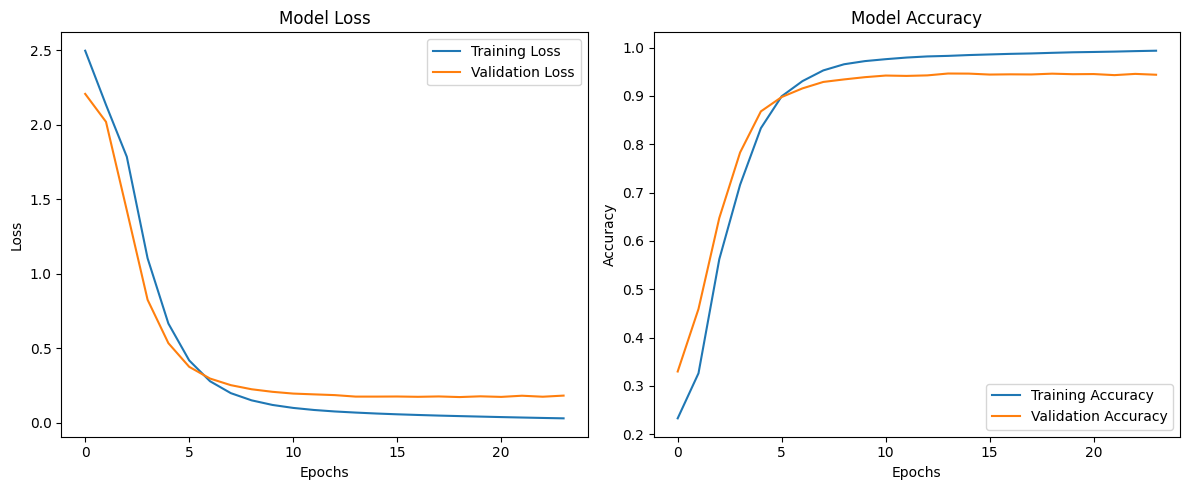

In [ ]:
gal_tagger.plot_training_history()

In [46]:
gal_tagger.evaluate()
gal_tagger.save_model(model_folder="./models/gal", model_filename="initial_model")

27/27 [==============================] - 1s 18ms/step - loss: 0.1747 - accuracy: 0.9460
Model saved in ./models/gal\initial_model.keras
Training history saved in ./models/gal\initial_model_training_history.json


27/27 [==============================] - 3s 15ms/step


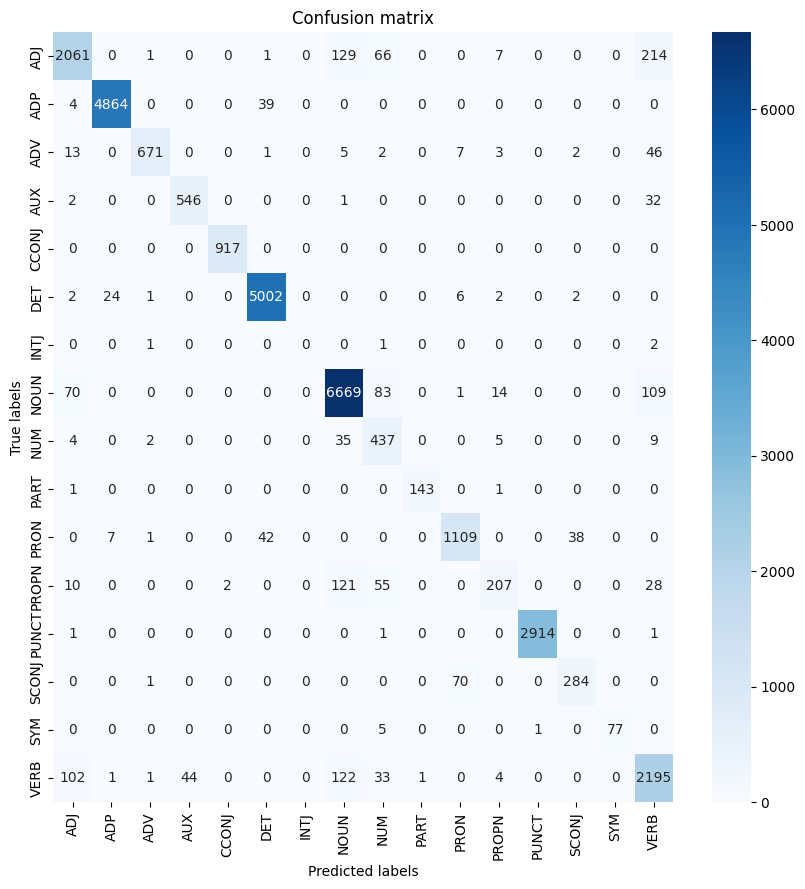

In [ ]:
gal_tagger.plot_confusion_matrix()

Now, we are going to perform a little hyperparameter tuning. We are going to tune each hyperparameter separately. The hyperparameters we are going to tune are:

- LSTM units: 16, 32, 64, 128
- Embedding size: 25, 50, 100, 200

With the English dataset we obtain the best results with 64 LSTM units, 50 embedding size, and 64 batch size, the values of the hyperparameters of the initial model trained for Galician. The goal is to check if the same hyperparameters work well for Galician or if there exist another configuration that works better.

To compare the resutls of the different models, we are going to use the accuracy on the test set. We are going to select the best model based on the accuracy on the test set.

In this case we are not going to train the model with different values for the batch size, as we saw that this hyperparameter does not have a significant impact on the model performance with the English dataset.


### LSTM units


In [ ]:
# gal_tagger.build_model(vocabulary_size=10000, units=16, output_dim=50, bidirectional=True)
# gal_tagger.train(batch_size=64, optimizer="adam", metrics=["accuracy"])

gal_tagger.load_model("units16", model_folder="./models/gal")
gal_tagger.show_training_log()

Model loaded from ./models/gal\units16.keras
Epoch 1/30 - Loss: 2.6857, Accuracy: 0.2175, Val Loss: 2.3512, Val Accuracy: 0.2283
Epoch 2/30 - Loss: 2.2239, Accuracy: 0.2495, Val Loss: 2.1191, Val Accuracy: 0.3050
Epoch 3/30 - Loss: 2.0237, Accuracy: 0.3621, Val Loss: 1.8956, Val Accuracy: 0.5167
Epoch 4/30 - Loss: 1.7494, Accuracy: 0.5940, Val Loss: 1.5821, Val Accuracy: 0.6413
Epoch 5/30 - Loss: 1.4219, Accuracy: 0.6670, Val Loss: 1.2645, Val Accuracy: 0.6781
Epoch 6/30 - Loss: 1.1260, Accuracy: 0.7125, Val Loss: 1.0066, Val Accuracy: 0.7450
Epoch 7/30 - Loss: 0.8898, Accuracy: 0.7899, Val Loss: 0.8064, Val Accuracy: 0.8134
Epoch 8/30 - Loss: 0.6985, Accuracy: 0.8553, Val Loss: 0.6461, Val Accuracy: 0.8614
Epoch 9/30 - Loss: 0.5413, Accuracy: 0.8986, Val Loss: 0.5229, Val Accuracy: 0.8890
Epoch 10/30 - Loss: 0.4201, Accuracy: 0.9225, Val Loss: 0.4361, Val Accuracy: 0.9015
Epoch 11/30 - Loss: 0.3337, Accuracy: 0.9363, Val Loss: 0.3780, Val Accuracy: 0.9103
Epoch 12/30 - Loss: 0.2735, A

In [ ]:
gal_tagger.evaluate()
gal_tagger.save_model(model_folder="./models/gal", model_filename="units16")

27/27 [==============================] - 4s 11ms/step - loss: 0.1987 - accuracy: 0.9415
Model saved in ./models/gal\units16.keras
Training history saved in ./models/gal\units16_training_history.json


In [ ]:
# gal_tagger.build_model(vocabulary_size=10000, units=32, output_dim=50, bidirectional=True)
# gal_tagger.train(batch_size=64, optimizer="adam", metrics=["accuracy"])

gal_tagger.load_model("units32", model_folder="./models/gal")
gal_tagger.show_training_log()

Model loaded from ./models/gal\units32.keras
Epoch 1/30 - Loss: 2.5961, Accuracy: 0.2368, Val Loss: 2.2603, Val Accuracy: 0.2280
Epoch 2/30 - Loss: 2.1662, Accuracy: 0.2823, Val Loss: 2.0750, Val Accuracy: 0.3474
Epoch 3/30 - Loss: 1.9350, Accuracy: 0.5144, Val Loss: 1.7191, Val Accuracy: 0.5830
Epoch 4/30 - Loss: 1.4746, Accuracy: 0.6124, Val Loss: 1.2204, Val Accuracy: 0.6604
Epoch 5/30 - Loss: 1.0325, Accuracy: 0.7062, Val Loss: 0.8477, Val Accuracy: 0.7722
Epoch 6/30 - Loss: 0.7021, Accuracy: 0.8222, Val Loss: 0.5864, Val Accuracy: 0.8575
Epoch 7/30 - Loss: 0.4723, Accuracy: 0.8927, Val Loss: 0.4283, Val Accuracy: 0.8930
Epoch 8/30 - Loss: 0.3242, Accuracy: 0.9261, Val Loss: 0.3337, Val Accuracy: 0.9104
Epoch 9/30 - Loss: 0.2325, Accuracy: 0.9484, Val Loss: 0.2774, Val Accuracy: 0.9230
Epoch 10/30 - Loss: 0.1771, Accuracy: 0.9604, Val Loss: 0.2477, Val Accuracy: 0.9285
Epoch 11/30 - Loss: 0.1431, Accuracy: 0.9685, Val Loss: 0.2273, Val Accuracy: 0.9342
Epoch 12/30 - Loss: 0.1207, A

In [ ]:
gal_tagger.evaluate()
gal_tagger.save_model(model_folder="./models/gal", model_filename="units32")

27/27 [==============================] - 4s 11ms/step - loss: 0.1789 - accuracy: 0.9455
Model saved in ./models/gal\units32.keras
Training history saved in ./models/gal\units32_training_history.json


In [ ]:
# gal_tagger.build_model(vocabulary_size=10000, units=128, output_dim=50, bidirectional=True)
# gal_tagger.train(batch_size=64, optimizer="adam", metrics=["accuracy"])

gal_tagger.load_model("units128", model_folder="./models/gal")
gal_tagger.show_training_log()

Model loaded from ./models/gal\units128.keras
Epoch 1/20 - Loss: 2.3940, Accuracy: 0.2277, Val Loss: 2.1700, Val Accuracy: 0.3195
Epoch 2/20 - Loss: 2.0745, Accuracy: 0.4089, Val Loss: 1.8733, Val Accuracy: 0.5590
Epoch 3/20 - Loss: 1.4578, Accuracy: 0.6319, Val Loss: 1.0031, Val Accuracy: 0.7085
Epoch 4/20 - Loss: 0.7894, Accuracy: 0.7800, Val Loss: 0.6039, Val Accuracy: 0.8266
Epoch 5/20 - Loss: 0.4785, Accuracy: 0.8656, Val Loss: 0.4030, Val Accuracy: 0.8955
Epoch 6/20 - Loss: 0.2929, Accuracy: 0.9289, Val Loss: 0.2914, Val Accuracy: 0.9260
Epoch 7/20 - Loss: 0.1871, Accuracy: 0.9588, Val Loss: 0.2341, Val Accuracy: 0.9364
Epoch 8/20 - Loss: 0.1310, Accuracy: 0.9713, Val Loss: 0.2097, Val Accuracy: 0.9389
Epoch 9/20 - Loss: 0.1006, Accuracy: 0.9765, Val Loss: 0.1996, Val Accuracy: 0.9358
Epoch 10/20 - Loss: 0.0830, Accuracy: 0.9802, Val Loss: 0.1852, Val Accuracy: 0.9428
Epoch 11/20 - Loss: 0.0710, Accuracy: 0.9826, Val Loss: 0.1842, Val Accuracy: 0.9426
Epoch 12/20 - Loss: 0.0621, 

In [ ]:
gal_tagger.evaluate()
gal_tagger.save_model(model_folder="./models/gal", model_filename="units128")

27/27 [==============================] - 4s 22ms/step - loss: 0.1751 - accuracy: 0.9462
Model saved in ./models/gal\units128.keras
Training history saved in ./models/gal\units128_training_history.json


#### Best model (LSTM units)

Using this dataset, we achieve higher accuracy on the test set with a model of 128 LSTM units. The test set accuracy is 0.9462, reflecting a **0.07%** improvement over the initial model. This improvement is minor, so in a real-world scenario, it would be wise to assess whether this performance gain justifies the additional computational cost of using a model with more LSTM units.

Similarly to the case with English, we observe that overfitting begins around the 5th or 6th epoch. From this point onward, both accuracy and loss stop improving significantly on the validation set, while these same metrics continue to improve on the training set.


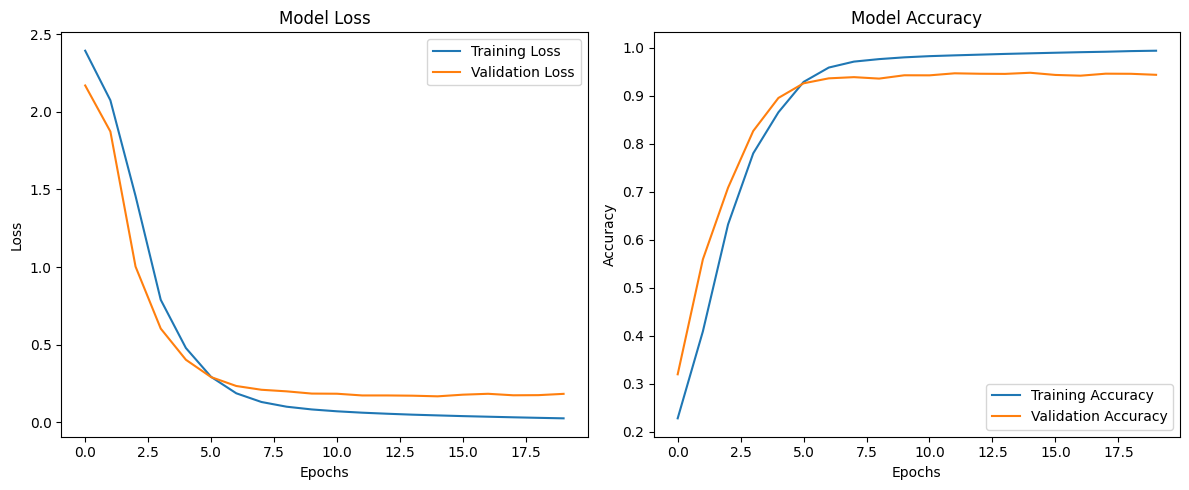

In [ ]:
gal_tagger.plot_training_history()

The results on the test set of the different models are summarized in the following table:

| **LSTM units** | **Acccuracy** |  **Loss**  |
| :------------: | :-----------: | :--------: |
|       16       |    0.9415     |   0.1987   |
|       32       |    0.9455     |   0.1789   |
|       64       |    0.9448     |   0.1781   |
|      128       |  **0.9462**   | **0.1751** |

For the next experiments we are going to use 128 LSTM units.


### Embedding size


In [ ]:
# gal_tagger.build_model(vocabulary_size=10000, units=128, output_dim=25, bidirectional=True)
# gal_tagger.train(batch_size=64, optimizer="adam", metrics=["accuracy"])

gal_tagger.load_model("embed25", model_folder="./models/gal")
gal_tagger.show_training_log()

Model loaded from ./models/gal\embed25.keras
Epoch 1/24 - Loss: 2.4255, Accuracy: 0.2211, Val Loss: 2.2002, Val Accuracy: 0.2467
Epoch 2/24 - Loss: 2.1563, Accuracy: 0.3086, Val Loss: 2.0673, Val Accuracy: 0.4949
Epoch 3/24 - Loss: 1.8604, Accuracy: 0.5555, Val Loss: 1.4937, Val Accuracy: 0.6197
Epoch 4/24 - Loss: 1.1832, Accuracy: 0.6703, Val Loss: 0.9394, Val Accuracy: 0.7268
Epoch 5/24 - Loss: 0.8019, Accuracy: 0.7786, Val Loss: 0.6600, Val Accuracy: 0.8098
Epoch 6/24 - Loss: 0.5412, Accuracy: 0.8490, Val Loss: 0.4557, Val Accuracy: 0.8711
Epoch 7/24 - Loss: 0.3613, Accuracy: 0.9027, Val Loss: 0.3440, Val Accuracy: 0.9012
Epoch 8/24 - Loss: 0.2532, Accuracy: 0.9355, Val Loss: 0.2774, Val Accuracy: 0.9201
Epoch 9/24 - Loss: 0.1847, Accuracy: 0.9542, Val Loss: 0.2389, Val Accuracy: 0.9301
Epoch 10/24 - Loss: 0.1405, Accuracy: 0.9661, Val Loss: 0.2265, Val Accuracy: 0.9309
Epoch 11/24 - Loss: 0.1122, Accuracy: 0.9731, Val Loss: 0.1993, Val Accuracy: 0.9416
Epoch 12/24 - Loss: 0.0930, A

In [ ]:
gal_tagger.evaluate()
gal_tagger.save_model(model_folder="./models/gal", model_filename="embed25")

27/27 [==============================] - 5s 31ms/step - loss: 0.1743 - accuracy: 0.9461
Model saved in ./models/gal\embed25.keras
Training history saved in ./models/gal\embed25_training_history.json


In [ ]:
# gal_tagger.build_model(vocabulary_size=10000, units=128, output_dim=50, bidirectional=True)
# gal_tagger.train(batch_size=64, optimizer="adam", metrics=["accuracy"])

gal_tagger.load_model("embed50", model_folder="./models/gal")
gal_tagger.show_training_log()

Model loaded from ./models/gal\embed50.keras
Epoch 1/20 - Loss: 2.4018, Accuracy: 0.2251, Val Loss: 2.1784, Val Accuracy: 0.2310
Epoch 2/20 - Loss: 2.0939, Accuracy: 0.3737, Val Loss: 1.9117, Val Accuracy: 0.5577
Epoch 3/20 - Loss: 1.5227, Accuracy: 0.6182, Val Loss: 1.0574, Val Accuracy: 0.6879
Epoch 4/20 - Loss: 0.8426, Accuracy: 0.7668, Val Loss: 0.6350, Val Accuracy: 0.8235
Epoch 5/20 - Loss: 0.5042, Accuracy: 0.8571, Val Loss: 0.4109, Val Accuracy: 0.8829
Epoch 6/20 - Loss: 0.3076, Accuracy: 0.9144, Val Loss: 0.3005, Val Accuracy: 0.9133
Epoch 7/20 - Loss: 0.1944, Accuracy: 0.9525, Val Loss: 0.2352, Val Accuracy: 0.9323
Epoch 8/20 - Loss: 0.1331, Accuracy: 0.9689, Val Loss: 0.2076, Val Accuracy: 0.9379
Epoch 9/20 - Loss: 0.1010, Accuracy: 0.9760, Val Loss: 0.1937, Val Accuracy: 0.9390
Epoch 10/20 - Loss: 0.0819, Accuracy: 0.9797, Val Loss: 0.1794, Val Accuracy: 0.9433
Epoch 11/20 - Loss: 0.0704, Accuracy: 0.9823, Val Loss: 0.1791, Val Accuracy: 0.9450
Epoch 12/20 - Loss: 0.0623, A

In [ ]:
gal_tagger.evaluate()
gal_tagger.save_model(model_folder="./models/gal", model_filename="embed50")

27/27 [==============================] - 5s 29ms/step - loss: 0.1707 - accuracy: 0.9469
Model saved in ./models/gal\embed50.keras
Training history saved in ./models/gal\embed50_training_history.json


In [ ]:
# gal_tagger.build_model(vocabulary_size=10000, units=128, output_dim=100, bidirectional=True)
# gal_tagger.train(batch_size=64, optimizer="adam", metrics=["accuracy"])

gal_tagger.load_model("embed100", model_folder="./models/gal")
gal_tagger.show_training_log()

Model loaded from ./models/gal\embed100.keras
Epoch 1/20 - Loss: 2.3692, Accuracy: 0.2624, Val Loss: 2.1254, Val Accuracy: 0.3945
Epoch 2/20 - Loss: 1.9300, Accuracy: 0.4937, Val Loss: 1.5440, Val Accuracy: 0.6146
Epoch 3/20 - Loss: 1.0873, Accuracy: 0.7048, Val Loss: 0.7143, Val Accuracy: 0.8034
Epoch 4/20 - Loss: 0.5255, Accuracy: 0.8517, Val Loss: 0.3881, Val Accuracy: 0.8904
Epoch 5/20 - Loss: 0.2646, Accuracy: 0.9303, Val Loss: 0.2618, Val Accuracy: 0.9265
Epoch 6/20 - Loss: 0.1542, Accuracy: 0.9621, Val Loss: 0.2125, Val Accuracy: 0.9375
Epoch 7/20 - Loss: 0.1074, Accuracy: 0.9730, Val Loss: 0.1967, Val Accuracy: 0.9391
Epoch 8/20 - Loss: 0.0841, Accuracy: 0.9781, Val Loss: 0.1826, Val Accuracy: 0.9437
Epoch 9/20 - Loss: 0.0690, Accuracy: 0.9819, Val Loss: 0.1739, Val Accuracy: 0.9465
Epoch 10/20 - Loss: 0.0592, Accuracy: 0.9841, Val Loss: 0.1707, Val Accuracy: 0.9473
Epoch 11/20 - Loss: 0.0519, Accuracy: 0.9861, Val Loss: 0.1715, Val Accuracy: 0.9463
Epoch 12/20 - Loss: 0.0461, 

In [ ]:
gal_tagger.evaluate()
gal_tagger.save_model(model_folder="./models/gal", model_filename="embed100")

27/27 [==============================] - 5s 30ms/step - loss: 0.1719 - accuracy: 0.9473
Model saved in ./models/gal\embed100.keras
Training history saved in ./models/gal\embed100_training_history.json


In [ ]:
# gal_tagger.build_model(vocabulary_size=10000, units=128, output_dim=200, bidirectional=True)
# gal_tagger.train(batch_size=64, optimizer="adam", metrics=["accuracy"])

gal_tagger.load_model("embed200", model_folder="./models/gal")
gal_tagger.show_training_log()

Model loaded from ./models/gal\embed200.keras
Epoch 1/14 - Loss: 2.3284, Accuracy: 0.2984, Val Loss: 2.0029, Val Accuracy: 0.5019
Epoch 2/14 - Loss: 1.5610, Accuracy: 0.6111, Val Loss: 0.9606, Val Accuracy: 0.7350
Epoch 3/14 - Loss: 0.6715, Accuracy: 0.8132, Val Loss: 0.4395, Val Accuracy: 0.8731
Epoch 4/14 - Loss: 0.2985, Accuracy: 0.9179, Val Loss: 0.2658, Val Accuracy: 0.9221
Epoch 5/14 - Loss: 0.1485, Accuracy: 0.9648, Val Loss: 0.2149, Val Accuracy: 0.9338
Epoch 6/14 - Loss: 0.0968, Accuracy: 0.9764, Val Loss: 0.1873, Val Accuracy: 0.9424
Epoch 7/14 - Loss: 0.0743, Accuracy: 0.9810, Val Loss: 0.1851, Val Accuracy: 0.9405
Epoch 8/14 - Loss: 0.0608, Accuracy: 0.9839, Val Loss: 0.1699, Val Accuracy: 0.9467
Epoch 9/14 - Loss: 0.0516, Accuracy: 0.9863, Val Loss: 0.1648, Val Accuracy: 0.9485
Epoch 10/14 - Loss: 0.0447, Accuracy: 0.9879, Val Loss: 0.1674, Val Accuracy: 0.9475
Epoch 11/14 - Loss: 0.0387, Accuracy: 0.9899, Val Loss: 0.1723, Val Accuracy: 0.9456
Epoch 12/14 - Loss: 0.0335, 

In [ ]:
gal_tagger.evaluate()
gal_tagger.save_model(model_folder="./models/gal", model_filename="embed200")

27/27 [==============================] - 4s 29ms/step - loss: 0.1707 - accuracy: 0.9469
Model saved in ./models/gal\embed200.keras
Training history saved in ./models/gal\embed200_training_history.json


#### Best model (embedding size)

The best model taking into account the accuracy on the test set is the one with an embedding size of 100, but if we consider the loss on the test set, there is a tie between the models with an embedding size of 50 and 200. Analysing the results, clearly, the embedding size has no significant effect on the model performance. Therefore, we choose a embedding size of 50, as it was the first one that we used.


The results on the test set of the different models are summarized in the following table:

| **Embedding size** | **Acccuracy** |  **Loss**  |
| :----------------: | :-----------: | :--------: |
|         25         |    0.9461     |   0.1743   |
|         50         |    0.9469     | **0.1707** |
|        100         |  **0.9473**   |   0.1719   |
|        200         |    0.9469     | **0.1707** |


### Best model

To select the best model, we will disregard experiments related to embedding size, as we have concluded that embedding size does not significantly affect model performance. Thus, we will choose the model with 128 LSTM units, an embedding size of 50, and a batch size of 64, as it achieved the highest accuracy on the test set.

In the confusion matrix, we can see that the model struggles most with the 'PROPN' tag, often misclassifying it as 'NOUN', 'NUM', or 'VERB'. However, the model performs very well in classifying the 'PUNCT' tag.

Parameters of the best model (units128):

- `Vocabulary size`: 10,000
- `Embedding size`: 50
- `LSTM units`: 128
- `Bidirectional`: True
- `Batch size`: 64


Model loaded from ./models/gal\units128.keras
27/27 [==============================] - 4s 44ms/step


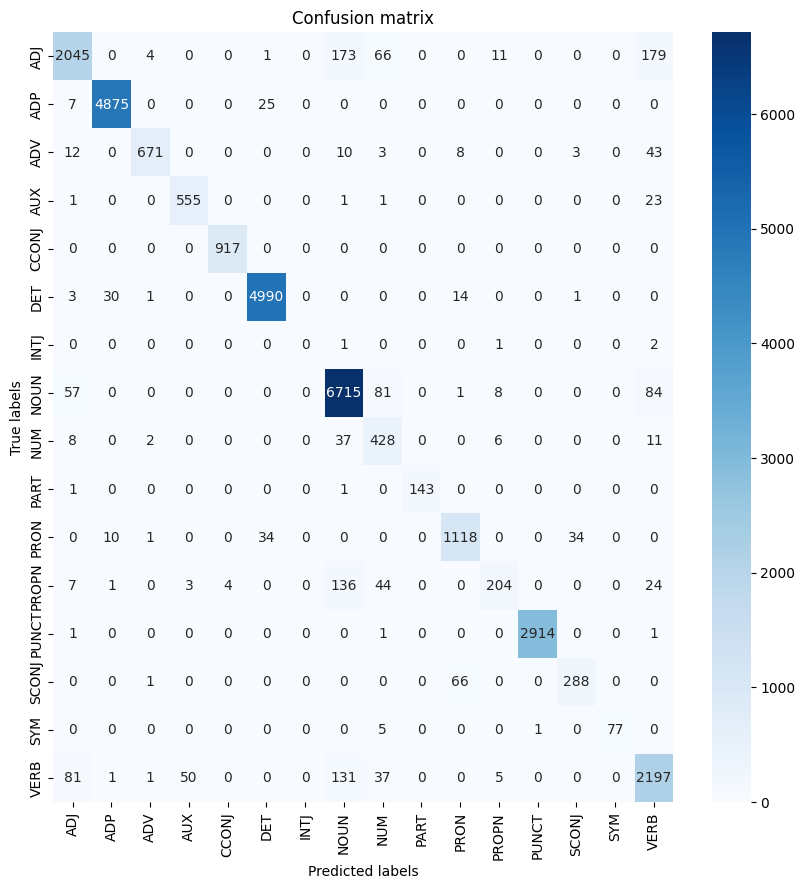

In [ ]:
gal_tagger.load_model("units128", model_folder="./models/gal")
gal_tagger.evaluate()
gal_tagger.plot_confusion_matrix()